# To Run:
- You need to have a local installation of pytorch and its dependencies (not in this ntbk)
- You need the 5 .npz files named `_0.npz` to `_4.npz` in a directory and change it in chat_train model config.
- To generate a saved model (.pt), you need to run afresh e.g. Kernel > Restart and Clear Output. Because the files were all smushed into 1 notebook, there seems to be some conflict in variable name usage.

In [1]:
#!pip3 install tensorflow_addons

In [2]:
import keras
import keras.metrics
import numpy as np
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.losses import BinaryCrossentropy
from sklearn.utils import shuffle
import tensorflow as tf
import tensorflow_addons as tfa

from keras.activations import sigmoid, relu
from keras.regularizers import L2

import torch
from keras import Input, Model
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, BatchNormalization, LSTM, Bidirectional, Permute, \
    Reshape, GRU, Conv1D, MaxPooling1D, Activation, Dropout, GlobalAveragePooling1D, multiply, MultiHeadAttention, Add, \
    LayerNormalization, SeparableConvolution1D, Input, Layer, AveragePooling1D, Concatenate
from keras.models import Sequential
from keras.activations import relu, sigmoid
from keras.regularizers import l2
import tensorflow_addons as tfa
import sys
import os
import gc
import matplotlib.pyplot as plt

c:\Users\William\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\William\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you

In [3]:
THRESHOLD = 1
FOLD = 5
DATA_FREQ = 128 # (change to 64 for FREQ = 64)
EPOCHS = 1

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # -1 if you want to use CPU

!nvidia-smi
tf.test.gpu_device_name()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Sun May  5 13:19:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:01:00.0  On |                  Off |
|  0%   31C    P8             23W /  599W |     600MiB /  24564MiB |     28%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
# transformer.py

class Patches(Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, input):
        input = input[:, tf.newaxis, :, :]
        batch_size = tf.shape(input)[0]
        patches = tf.image.extract_patches(
            images=input,
            sizes=[1, 1, self.patch_size, 1],
            strides=[1, 1, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches,
                             [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim, l2_weight):
        super(PatchEncoder, self).__init__()
        self.projection_dim = projection_dim
        self.l2_weight = l2_weight
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim, kernel_regularizer=L2(l2_weight),
                                bias_regularizer=L2(l2_weight))
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) # + self.position_embedding(positions)
        return encoded


def mlp(x, hidden_units, dropout_rate, l2_weight):
    for _, units in enumerate(hidden_units):
        x = Dense(units, activation=None, kernel_regularizer=L2(l2_weight), bias_regularizer=L2(l2_weight))(x)
        x = tf.nn.gelu(x)
        x = Dropout(dropout_rate)(x)
    return x


def create_transformer_model(input_shape, num_patches,
                             projection_dim, transformer_layers,
                             num_heads, transformer_units, mlp_head_units,
                             num_classes, drop_out, reg, l2_weight, demographic=False):
    if reg:
        activation = None
    else:
        activation = 'sigmoid'
    inputs = Input(shape=input_shape)
    patch_size = input_shape[0] / num_patches
    if demographic:
        normalized_inputs = tfa.layers.InstanceNormalization(axis=-1, epsilon=1e-6, center=False, scale=False,
                                                             beta_initializer="glorot_uniform",
                                                             gamma_initializer="glorot_uniform")(inputs[:,:,:-1])
        demo = inputs[:, :12, -1]

    else:
        normalized_inputs = tfa.layers.InstanceNormalization(axis=-1, epsilon=1e-6, center=False, scale=False,
                                                             beta_initializer="glorot_uniform",
                                                             gamma_initializer="glorot_uniform")(inputs)

    # patches = Reshape((num_patches, -1))(normalized_inputs)
    patches = Patches(patch_size=patch_size)(normalized_inputs)
    encoded_patches = PatchEncoder(num_patches=num_patches, projection_dim=projection_dim, l2_weight=l2_weight)(patches)
    for i in range(transformer_layers):
        x1 = encoded_patches # LayerNormalization(epsilon=1e-6)(encoded_patches) # TODO
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=drop_out, kernel_regularizer=L2(l2_weight),  # i *
            bias_regularizer=L2(l2_weight))(x1, x1)
        x2 = Add()([attention_output, encoded_patches])
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, transformer_units, drop_out, l2_weight)  # i *
        encoded_patches = Add()([x3, x2])

    x = LayerNormalization(epsilon=1e-6)(encoded_patches)
    x = GlobalAveragePooling1D()(x)
    #x = Concatenate()([x, demo])
    features = mlp(x, mlp_head_units, 0.0, l2_weight)

    logits = Dense(num_classes, kernel_regularizer=L2(l2_weight), bias_regularizer=L2(l2_weight),
                   activation=activation)(features)

    return tf.keras.Model(inputs=inputs, outputs=logits)



def create_hybrid_transformer_model(input_shape):
    transformer_units =  [32,32]
    transformer_layers = 2
    num_heads = 4
    l2_weight = 0.001
    drop_out= 0.25
    mlp_head_units = [256, 128]
    num_patches=30
    projection_dim=  32

    # Conv1D(32...
    input1 = Input(shape=input_shape)
    conv11 = Conv1D(16, 256)(input1) #13
    conv12 = Conv1D(16, 256)(input1) #13
    conv13 = Conv1D(16, 256)(input1) #13

    pwconv1 = SeparableConvolution1D(32, 1)(input1)
    pwconv2 = SeparableConvolution1D(32, 1)(pwconv1)

    conv21 = Conv1D(16, 256)(conv11) # 7
    conv22 = Conv1D(16, 256)(conv12) # 7
    conv23 = Conv1D(16, 256)(conv13) # 7

    concat = keras.layers.concatenate([conv21, conv22, conv23], axis=-1)
    concat = Dense(64, activation=relu)(concat) #192
    concat = Dense(64, activation=sigmoid)(concat) #192
    concat = SeparableConvolution1D(32,1)(concat)
    concat = keras.layers.concatenate([concat, pwconv2], axis=1)

    ####################################################################################################################
    patch_size = input_shape[0] / num_patches

    normalized_inputs = tfa.layers.InstanceNormalization(axis=-1, epsilon=1e-6, center=False, scale=False,
                                                             beta_initializer="glorot_uniform",
                                                             gamma_initializer="glorot_uniform")(concat)

    # patches = Reshape((num_patches, -1))(normalized_inputs)
    patches = Patches(patch_size=patch_size)(normalized_inputs)
    encoded_patches = PatchEncoder(num_patches=num_patches, projection_dim=projection_dim, l2_weight=l2_weight)(patches)
    for i in range(transformer_layers):
        x1 = encoded_patches # LayerNormalization(epsilon=1e-6)(encoded_patches) # TODO
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=drop_out, kernel_regularizer=L2(l2_weight),  # i *
            bias_regularizer=L2(l2_weight))(x1, x1)
        x2 = Add()([attention_output, encoded_patches])
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, transformer_units, drop_out, l2_weight)  # i *
        encoded_patches = Add()([x3, x2])

    x = LayerNormalization(epsilon=1e-6)(encoded_patches)
    x = GlobalAveragePooling1D()(x)
    #x = Concatenate()([x, demo])
    features = mlp(x, mlp_head_units, 0.0, l2_weight)

    logits = Dense(1, kernel_regularizer=L2(l2_weight), bias_regularizer=L2(l2_weight),
                   activation='sigmoid')(features)

    ####################################################################################################################

    model = Model(inputs=input1, outputs=logits)
    return model

In [7]:
# transformer.py

def create_cnn_model(input_shape):
    model = Sequential()
    for i in range(5): # 10
        model.add(Conv1D(45, 32, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(relu))
        model.add(MaxPooling1D())
        model.add(Dropout(0.5))

    model.add(Flatten())
    for i in range(2): #4
        model.add(Dense(512))
        model.add(BatchNormalization())
        model.add(Activation(relu))
        model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    return model


def create_cnnlstm_model(input_a_shape, weight=1e-3):
    cnn_filters = 32 # 128
    cnn_kernel_size = 4 # 4
    input1 = Input(shape=input_a_shape)
    input1 = tfa.layers.InstanceNormalization(axis=-1, epsilon=1e-6, center=False, scale=False,
                                              beta_initializer="glorot_uniform",
                                              gamma_initializer="glorot_uniform")(input1)
    x1 = Conv1D(cnn_filters, cnn_kernel_size, activation='relu')(input1)
    x1 = Conv1D(cnn_filters, cnn_kernel_size, activation='relu')(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling1D()(x1)

    x1 = Conv1D(cnn_filters, cnn_kernel_size, activation='relu')(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling1D()(x1)

    x1 = Conv1D(cnn_filters, cnn_kernel_size, activation='relu')(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling1D()(x1)

    x1 = LSTM(32, return_sequences=True)(x1) #256
    x1 = LSTM(32, return_sequences=True)(x1) #256
    x1 = LSTM(32)(x1) #256
    x1 = Flatten()(x1)

    x1 = Dense(32, activation='relu')(x1) #64
    x1 = Dense(32, activation='relu')(x1) #64
    outputs = Dense(1, activation='sigmoid')(x1)

    model = Model(inputs=input1, outputs=outputs)
    return model


def create_semscnn_model(input_a_shape):
    input1 = Input(shape=input_a_shape)
    # input1 = tfa.layers.InstanceNormalization(axis=-1, epsilon=1e-6, center=False, scale=False,
    #                                           beta_initializer="glorot_uniform",
    #                                           gamma_initializer="glorot_uniform")(input1)
    x1 = Conv1D(45, 32, strides=1)(input1) #kernel_size=11
    x1 = Conv1D(45, 32, strides=2)(x1) #64 kernel_size=11
    x1 = BatchNormalization()(x1)
    x1 = Activation(relu)(x1)
    x1 = MaxPooling1D()(x1)

    x1 = Conv1D(45, 32, strides=2)(x1) #64 kernel_size=11
    x1 = BatchNormalization()(x1)
    x1 = Activation(relu)(x1)
    x1 = MaxPooling1D()(x1)

    x1 = Conv1D(45, 32, strides=2)(x1) #64 kernel_size=11
    x1 = BatchNormalization()(x1)
    x1 = Activation(relu)(x1)
    x1 = MaxPooling1D()(x1)

    squeeze = Flatten()(x1)
    excitation = Dense(128, activation='relu')(squeeze)
    excitation = Dense(64, activation='relu')(excitation)
    logits = Dense(1, activation='sigmoid')(excitation)
    model = Model(inputs=input1, outputs=logits)
    return model


model_dict = {

    "cnn": create_cnn_model((30 * DATA_FREQ, 3)),
    "sem-mscnn": create_semscnn_model((30 * DATA_FREQ, 3)),
    "cnn-lstm": create_cnnlstm_model((30 * DATA_FREQ, 3)),

    ### team 4 change ###
    "hybrid": create_hybrid_transformer_model((30 * DATA_FREQ, 3)),
}


def get_model(config):
    if config["model_name"].split('_')[0] == "Transformer":
        return create_transformer_model(input_shape=(30 * DATA_FREQ, len(config["channels"])),
                                        num_patches=config["num_patches"], projection_dim=config["transformer_units"],
                                        transformer_layers=config["transformer_layers"], num_heads=config["num_heads"],
                                        transformer_units=[config["transformer_units"] * 2,
                                                           config["transformer_units"]],
                                        mlp_head_units=[256, 128], num_classes=1, drop_out=config["drop_out_rate"],
                                        reg=config["regression"], l2_weight=config["regularization_weight"])
    else:
        return model_dict.get(config["model_name"].split('_')[0])


if __name__ == "__main__":
    config = {
        "model_name": "Transformer",
        "regression": False,

        "transformer_layers": 5,  # best 5
        "drop_out_rate": 0.25,
        "num_patches": 20,  # best
        "transformer_units": 32,  # best 32
        "regularization_weight": 0.001,  # best 0.001
        "num_heads": 4,
        "epochs": 100,  # best
        "channels": [14, 18, 19, 20],
    }
    model = get_model(config)
    model.build(input_shape=(1, 30 * DATA_FREQ, 10))
    print(model.summary())

    #########################
    torch.save(model, f"./{config['model_name']}_model.pt")

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 3840, 4)]    0           []                               
                                                                                                  
 instance_normalization_2 (Inst  (None, 3840, 4)     0           ['input_5[0][0]']                
 anceNormalization)                                                                               
                                                                                                  
 patches_1 (Patches)            (None, None, 768)    0           ['instance_normalization_2[0][0]'
                                                                 ]                                
                                                                                            

INFO:tensorflow:Assets written to: ram://f5e2aa45-8963-4fe9-b110-90064e67b99a/assets


INFO:tensorflow:Assets written to: ram://f5e2aa45-8963-4fe9-b110-90064e67b99a/assets


In [8]:
def lr_schedule(epoch, lr):
    if epoch > 50 and (epoch - 1) % 5 == 0:
        lr *= 0.5
    return lr

def data_generator(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.npz'):
            data = np.load(os.path.join(directory, filename), allow_pickle=True) # allow_pickle=Truemmap_mode='r'
            x = data['x']
            y = data['y_apnea'] + data['y_hypopnea']
            del data
            gc.collect()
            yield x, y

def train(config, fold=None):
    x = [None]*FOLD
    y = [None]*FOLD
    data_gen = data_generator(config["data_path"])
    for i in range(FOLD):
        x[i], y[i] = next(data_gen)
        x[i], y[i] = shuffle(x[i], y[i])
        x[i] = np.nan_to_num(x[i], nan=1)
        if config["regression"]:
            y[i] = np.sqrt(y[i])
            y[i][y[i] != 0] += 2
        else:
            y[i] = np.where(y[i] >= THRESHOLD, 1, 0)

        x[i] = x[i][:, :, config["channels"]]  # CHANNEL SELECTION
    del data_gen
    gc.collect()
    ########################################################################################
    folds = range(FOLD) if fold is None else [fold]

    for fold in folds:
        first = True
        for i in range(5):
            if i != fold:
                if first:
                    x_train = x[i]
                    y_train = y[i]
                    first = False
                else:
                    x_train = np.concatenate((x_train, x[i]))
                    y_train = np.concatenate((y_train, y[i]))

        model = get_model(config)
        if config["regression"]:
            model.compile(optimizer="adam", loss=BinaryCrossentropy())
            early_stopper = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        else:
            model.compile(optimizer="adam", loss=BinaryCrossentropy(),
                          metrics=[keras.metrics.Precision(), keras.metrics.Recall()])
            early_stopper = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lr_scheduler = LearningRateScheduler(lr_schedule)

        print(f"train {x_train.shape}")
        model.fit(x=x_train, y=y_train, batch_size=512, epochs=config["epochs"], validation_split=0.1,
                  callbacks=[early_stopper, lr_scheduler])
        ################################################################################################################
        model.save(config["model_path"] + str(fold))
        keras.backend.clear_session()

In [9]:
# metrics.py
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, average_precision_score, roc_auc_score


class FromLogitsMixin:
    def __init__(self, from_logits=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.from_logits = from_logits

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self.from_logits:
            y_pred = tf.nn.sigmoid(y_pred)
        return super().update_state(y_true, y_pred, sample_weight)


class AUC(FromLogitsMixin, tf.metrics.AUC):
    ...


class BinaryAccuracy(FromLogitsMixin, tf.metrics.BinaryAccuracy):
    ...


class TruePositives(FromLogitsMixin, tf.metrics.TruePositives):
    ...


class FalsePositives(FromLogitsMixin, tf.metrics.FalsePositives):
    ...


class TrueNegatives(FromLogitsMixin, tf.metrics.TrueNegatives):
    ...


class FalseNegatives(FromLogitsMixin, tf.metrics.FalseNegatives):
    ...


class Precision(FromLogitsMixin, tf.metrics.Precision):
    ...


class Recall(FromLogitsMixin, tf.metrics.Recall):
    ...


class F1Score(FromLogitsMixin, tfa.metrics.F1Score):
    ...


class Result:
    def __init__(self):
        self.accuracy_list = []
        self.sensitivity_list = []
        self.specificity_list = []
        self.f1_list = []
        self.auroc_list = []
        self.auprc_list = []
        self.precision_list = []

    def add(self, y_test, y_predict, y_score):
        C = confusion_matrix(y_test, y_predict, labels=(1, 0))
        TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]

        acc, sn, sp, pr = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP), 1. * TP / (
                TP + FP)
        f1 = f1_score(y_test, y_predict)
        auc = roc_auc_score(y_test, y_score)
        auprc = average_precision_score(y_test, y_score)

        self.accuracy_list.append(acc * 100)
        self.precision_list.append(pr * 100)
        self.sensitivity_list.append(sn * 100)
        self.specificity_list.append(sp * 100)
        self.f1_list.append(f1 * 100)
        self.auroc_list.append(auc * 100)
        self.auprc_list.append(auprc * 100)


    def get(self):
        out_str = "=========================================================================== \n"
        out_str += str(self.accuracy_list) + " \n"
        out_str += str(self.precision_list) + " \n"
        out_str += str(self.sensitivity_list) + " \n"
        out_str += str(self.specificity_list) + " \n"
        out_str += str(self.f1_list) + " \n"
        out_str += str(self.auroc_list) + " \n"
        out_str += str(self.auprc_list) + " \n"
        out_str += str("Accuracy: %.2f -+ %.3f" % (np.mean(self.accuracy_list), np.std(self.accuracy_list))) + " \n"
        out_str += str("Precision: %.2f -+ %.3f" % (np.mean(self.precision_list), np.std(self.precision_list))) + " \n"
        out_str += str(
            "Recall: %.2f -+ %.3f" % (np.mean(self.sensitivity_list), np.std(self.sensitivity_list))) + " \n"
        out_str += str(
            "Specifity: %.2f -+ %.3f" % (np.mean(self.specificity_list), np.std(self.specificity_list))) + " \n"
        out_str += str("F1: %.2f -+ %.3f" % (np.mean(self.f1_list), np.std(self.f1_list))) + " \n"
        out_str += str("AUROC: %.2f -+ %.3f" % (np.mean(self.auroc_list), np.std(self.auroc_list))) + " \n"
        out_str += str("AUPRC: %.2f -+ %.3f" % (np.mean(self.auprc_list), np.std(self.auprc_list))) + " \n"

        out_str += str("$ %.1f \pm %.1f$" % (np.mean(self.accuracy_list), np.std(self.accuracy_list))) + "& "
        out_str += str("$%.1f \pm %.1f$" % (np.mean(self.precision_list), np.std(self.precision_list))) + "& "
        out_str += str("$%.1f \pm %.1f$" % (np.mean(self.sensitivity_list), np.std(self.sensitivity_list))) + "& "
        out_str += str("$%.1f \pm %.1f$" % (np.mean(self.f1_list), np.std(self.f1_list))) + "& "
        out_str += str("$%.1f \pm %.1f$" % (np.mean(self.auroc_list), np.std(self.auroc_list))) + "& "

        return out_str

    def print(self):
        print(self.get())

    def visualize(self):
        metrics = {
            'Accuracy': self.accuracy_list,
            'Precision': self.precision_list,
            'Recall (Sensitivity)': self.sensitivity_list,
            'Specificity': self.specificity_list,
            'F1 Score': self.f1_list,
            'AUROC': self.auroc_list,
            'AUPRC': self.auprc_list
        }
        # Setup the subplot grid
        fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 22))
        axes = axes.flatten()  # Flatten to make indexing easier

        # Plot each metric
        for ax, (metric_name, values) in zip(axes, metrics.items()):
            ax.plot(values, label=f'{metric_name}', marker='o', linestyle='-')
            ax.set_title(metric_name)
            ax.set_xlabel('Epochs')
            ax.set_ylabel(metric_name)
            ax.legend(loc='best')

        # Remove the empty subplot (if any)
        if len(metrics) % 2 != 0:
            fig.delaxes(axes[-1])

        # Adjust layout
        plt.tight_layout()
        plt.show()


    def save(self, path, config):
        os.makedirs(os.path.dirname(path), exist_ok=True)

        with open(path, "w+") as file:
            file.write(str(config))
            file.write("\n")
            file.write(self.get())
            file.flush()

In [10]:
# tester.py

import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def test(config, fold=None):

    x = [None]*FOLD
    y = [None]*FOLD
    data_gen = data_generator(config["data_path"])
    for i in range(FOLD):
        x[i], y[i] = next(data_gen)
        x[i], y[i] = shuffle(x[i], y[i])
        x[i] = np.nan_to_num(x[i], nan=-1)
        y[i] = np.where(y[i] >= THRESHOLD, 1, 0)
        x[i] = x[i][:, :, config["channels"]]
    del data_gen
    gc.collect()
    ############################################################################
    result = Result()
    folds = range(FOLD) if fold is None else [fold]
    for fold in folds:
        x_test = x[fold]
        if config.get("test_noise_snr"):
            x_test = add_noise_to_data(x_test, config["test_noise_snr"])

        y_test = y[fold]  # For MultiClass keras.utils.to_categorical(y[fold], num_classes=2)

        model = tf.keras.models.load_model(config["model_path"] + str(fold), compile=False)

        predict = model.predict(x_test)
        y_score = predict
        y_predict = np.where(predict > 0.5, 1, 0)# For MultiClass np.argmax(y_score, axis=-1)

        result.add(y_test, y_predict, y_score)

    result.print()
    result.visualize()
    result.save("./results/" + config["model_name"] + ".txt", config)

    del x_test, y_test, model, predict, y_score, y_predict

In [ ]:
# variables

# 0- E1 - M2
# 1- E2 - M1

# 2- F3 - M2
# 3- F4 - M1
# 4- C3 - M2
# 5- C4 - M1
# 6- O1 - M2
# 7- O2 - M1

# 8- ECG3 - ECG1

# 9- CANULAFLOW
# 10- AIRFLOW
# 11- CHEST
# 12- ABD

# 13- SAO2
# 14- CAP
######### ADDED IN THIS STEP #########
# 15- RRI
# 16 Ramp

sig_dict_chat = {
    "EOG": [0, 1],
    "EEG": [4, 5],
    "ECG": [15,16],
    "Resp": [9, 10],
    "SPO2": [13],
    "CO2": [14],
}

channel_list_chat = [
    ["ECG", "SPO2"],

]

chat_config = {
    "data_path": "D:\\chat_128_FREQ_45\\",
    "model_path": "C:\\Users\William\\Documents\\Development\\Python projects\\Deeplearning healthcare\\Pediatric-Apnea-Detection\\Transformer_model.pt",
    # "model_name": "Transformer_chat_"+ chstr,
    "regression": False,

    "transformer_layers": 5,  # best 5
    "drop_out_rate": 0.25,  # best 0.25
    "num_patches": 30,  # best 30 TBD
    "transformer_units": 32,  # best 32
    "regularization_weight": 0.001,  # best 0.001
    "num_heads": 4,
    "epochs": EPOCHS,  # best 200
    # "channels": chs,
}

# "EOG LOC-M2",  # 0
# "EOG ROC-M1",  # 1
# "EEG C3-M2",  # 2
# "EEG C4-M1",  # 3
# "ECG EKG2-EKG",  # 4
#
# "RESP PTAF",  # 5
# "RESP AIRFLOW",  # 6
# "RESP THORACIC",  # 7
# "RESP ABDOMINAL",  # 8
# "SPO2",  # 9
# "CAPNO",  # 10

######### ADDED IN THIS STEP #########
# RRI #11
# Ramp #12
# Demo #13

sig_dict_nch = {"EOG": [0, 1],
            "EEG": [2, 3],
            "RESP": [5, 6],
            "SPO2": [9],
            "CO2": [10],
            "ECG": [11, 12],
            "DEMO": [13],
            }

channel_list_nch = [

    ["ECG", "SPO2"],

]

nch_config = {
    "data_path": "D:\\nch_128_FREQ_45\\",
    "model_path": "C:\\Users\William\\Documents\\Development\\Python projects\\Deeplearning healthcare\\Pediatric-Apnea-Detection\\Transformer_model.pt", # TODO: this is hybrid; the original is using sem-mscnn, but we need to modify transformer.py (above) to generate a .pt file for it
    # "model_name": "Transformer_nch_"+ chstr,
    "regression": False,

    "transformer_layers": 5,  # best 5
    "drop_out_rate": 0.25,  # best 0.25
    "num_patches": 30,  # best 30 TBD
    "transformer_units": 32,  # best 32
    "regularization_weight": 0.001,  # best 0.001
    "num_heads": 4,
    "epochs": EPOCHS,  # best 200
    # "channels": chs,
}

ECGSPO2 [15, 16, 13]
train (36633, 3840, 3)
Epoch 1/200
65/65 [==============================] - 7s 34ms/step - loss: 1.2895 - precision: 0.6594 - recall: 0.7867 - val_loss: 1.0358 - val_precision: 0.7631 - val_recall: 0.7611 - lr: 0.0010
Epoch 2/200
65/65 [==============================] - 1s 20ms/step - loss: 0.9175 - precision: 0.7371 - recall: 0.7955 - val_loss: 0.8357 - val_precision: 0.8080 - val_recall: 0.6994 - lr: 0.0010
Epoch 3/200
65/65 [==============================] - 1s 21ms/step - loss: 0.7674 - precision: 0.7576 - recall: 0.8021 - val_loss: 0.7193 - val_precision: 0.8253 - val_recall: 0.7300 - lr: 0.0010
Epoch 4/200
65/65 [==============================] - 1s 20ms/step - loss: 0.6847 - precision: 0.7696 - recall: 0.8074 - val_loss: 0.6686 - val_precision: 0.7366 - val_recall: 0.8892 - lr: 0.0010
Epoch 5/200
65/65 [==============================] - 1s 20ms/step - loss: 0.6355 - precision: 0.7743 - recall: 0.8160 - val_loss: 0.6177 - val_precision: 0.8243 - val_recall: 0

INFO:tensorflow:Assets written to: C:\Users\William\Documents\Development\Python projects\Deeplearning healthcare\Pediatric-Apnea-Detection\chat_Transformer_model.pt0\assets


INFO:tensorflow:Assets written to: C:\Users\William\Documents\Development\Python projects\Deeplearning healthcare\Pediatric-Apnea-Detection\chat_Transformer_model.pt0\assets


316/316 [==============================] - 2s 5ms/step
[83.69856222112048] 
[83.8946117274168] 
[83.59652585866561] 
[83.80155409444112] 
[83.745303539648] 
[90.5766594638754] 
[89.58376676435508] 
Accuracy: 83.70 -+ 0.000 
Precision: 83.89 -+ 0.000 
Recall: 83.60 -+ 0.000 
Specifity: 83.80 -+ 0.000 
F1: 83.75 -+ 0.000 
AUROC: 90.58 -+ 0.000 
AUPRC: 89.58 -+ 0.000 
$ 83.7 \pm 0.0$& $83.9 \pm 0.0$& $83.6 \pm 0.0$& $83.7 \pm 0.0$& $90.6 \pm 0.0$& 


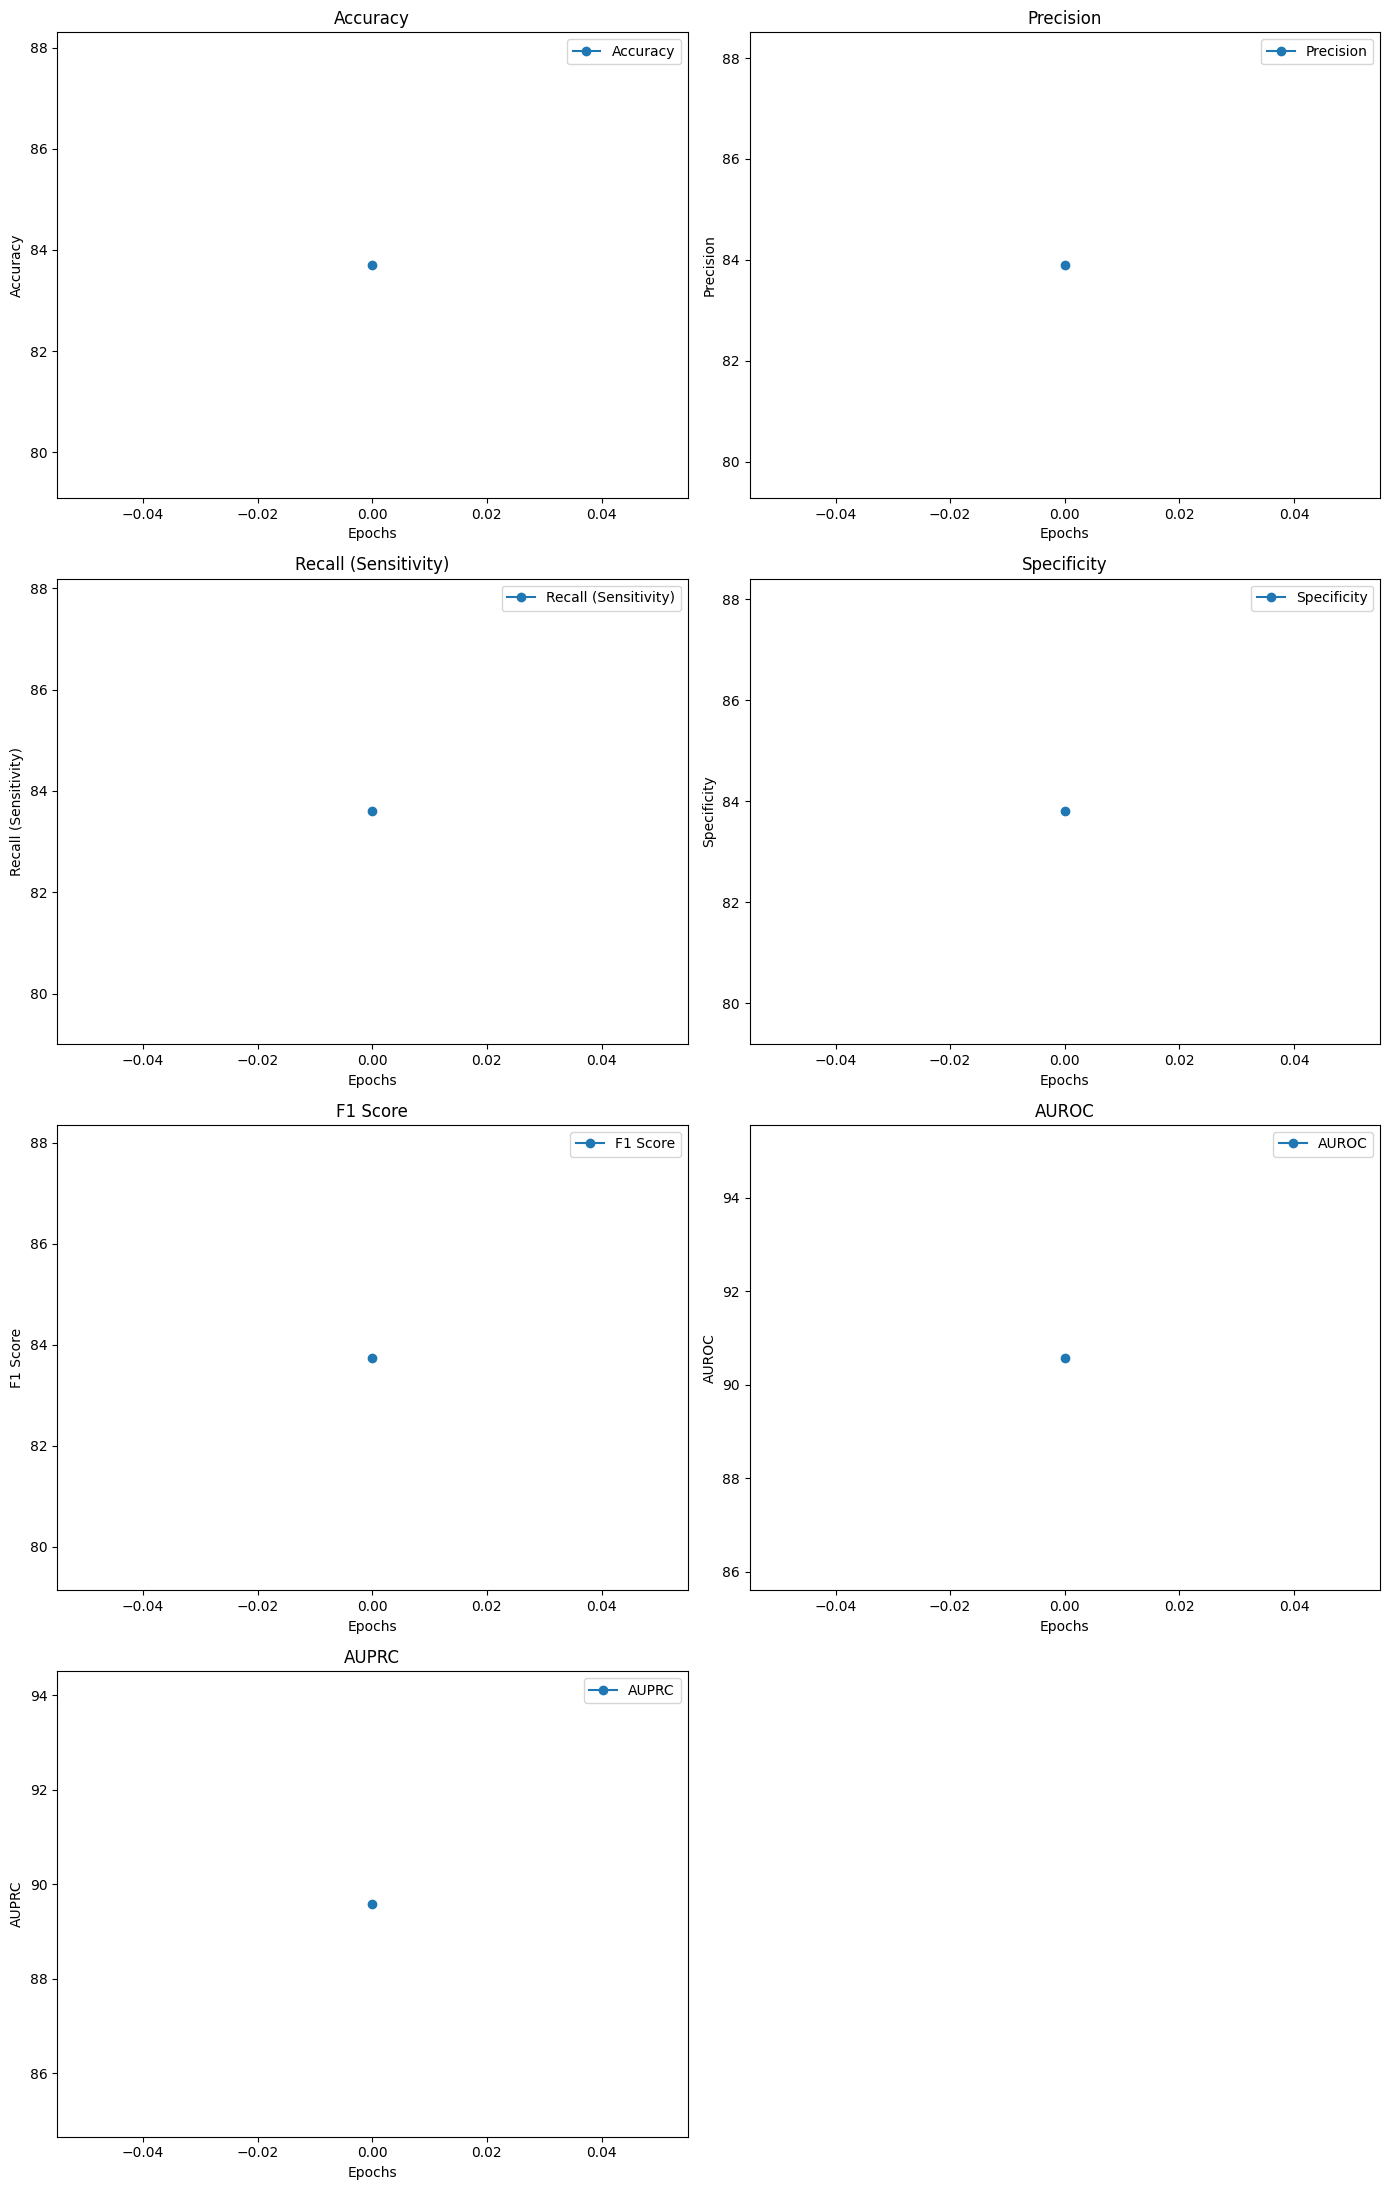

In [11]:
# main_chat_train.py

for ch in channel_list_chat:
    chs = []
    chstr = ""
    for name in ch:
        chstr += name
        chs = chs + sig_dict_chat[name]
    print(chstr, chs)
    config = chat_config.copy()
    config["model_name"] = "Transformer_chat_"+ chstr
    config["channels"] = chs
    train(config, 0)
    #test(config, 0)
    gc.collect()

train (1041, 3840, 3)
Epoch 1/200
2/2 [==============================] - 3s 599ms/step - loss: 1.6544 - precision: 0.6020 - recall: 0.8534 - val_loss: 1.5972 - val_precision: 0.5814 - val_recall: 0.9615 - lr: 0.0010
Epoch 2/200
2/2 [==============================] - 0s 46ms/step - loss: 1.5800 - precision: 0.6479 - recall: 0.9145 - val_loss: 1.4960 - val_precision: 0.6849 - val_recall: 0.9615 - lr: 0.0010
Epoch 3/200
2/2 [==============================] - 0s 45ms/step - loss: 1.4965 - precision: 0.7393 - recall: 0.8432 - val_loss: 1.4509 - val_precision: 0.6944 - val_recall: 0.9615 - lr: 0.0010
Epoch 4/200
2/2 [==============================] - 0s 36ms/step - loss: 1.4337 - precision: 0.7396 - recall: 0.8676 - val_loss: 1.4898 - val_precision: 0.6849 - val_recall: 0.9615 - lr: 0.0010
Epoch 5/200
2/2 [==============================] - 0s 44ms/step - loss: 1.4076 - precision: 0.7404 - recall: 0.8595 - val_loss: 1.4295 - val_precision: 0.6849 - val_recall: 0.9615 - lr: 0.0010
Epoch 6/200


INFO:tensorflow:Assets written to: C:\Users\William\Documents\Development\Python projects\Deeplearning healthcare\Pediatric-Apnea-Detection\nch_Transformer_model.pt0\assets


INFO:tensorflow:Assets written to: C:\Users\William\Documents\Development\Python projects\Deeplearning healthcare\Pediatric-Apnea-Detection\nch_Transformer_model.pt0\assets


18/18 [==============================] - 0s 10ms/step
[75.35971223021582] 
[73.88535031847134] 
[80.8362369337979] 
[69.51672862453532] 
[77.20465890183029] 
[81.56030206080075] 
[77.58508876106819] 
Accuracy: 75.36 -+ 0.000 
Precision: 73.89 -+ 0.000 
Recall: 80.84 -+ 0.000 
Specifity: 69.52 -+ 0.000 
F1: 77.20 -+ 0.000 
AUROC: 81.56 -+ 0.000 
AUPRC: 77.59 -+ 0.000 
$ 75.4 \pm 0.0$& $73.9 \pm 0.0$& $80.8 \pm 0.0$& $77.2 \pm 0.0$& $81.6 \pm 0.0$& 


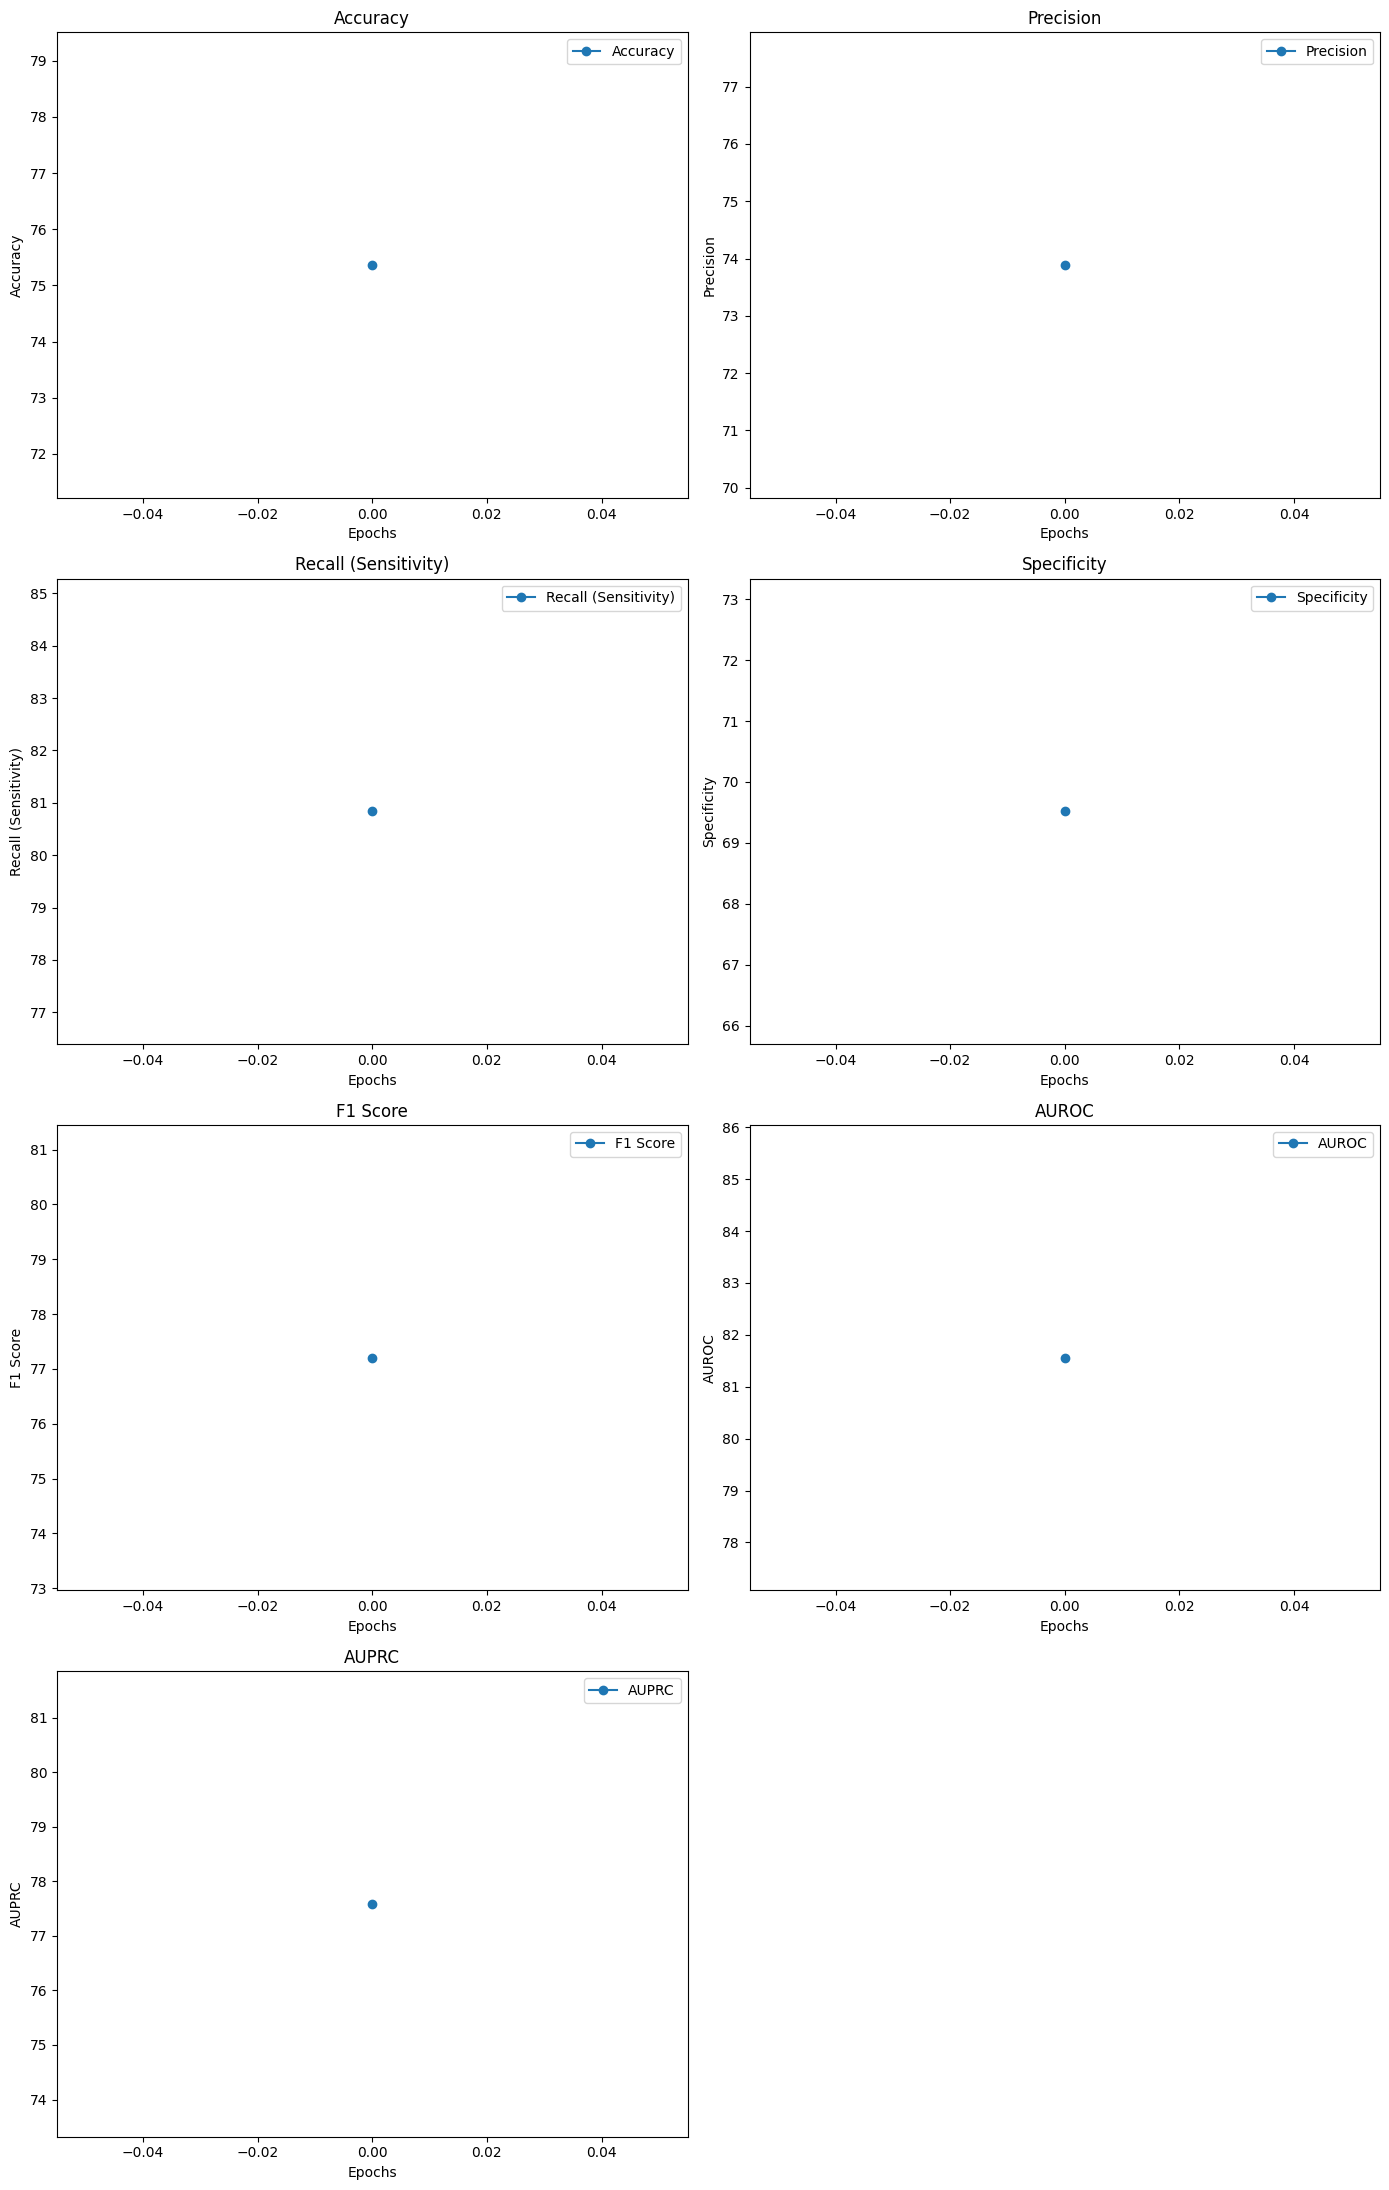

In [12]:
# main_nch_train.py

for ch in channel_list_nch:
    chs = []
    chstr = ""
    for name in ch:
        chstr += name
        chs = chs + sig_dict_bnch[name]
    config = nch_config.copy()
    config["model_name"] = "Transformer_chat_"+ chstr
    config["channels"] = chs
    train(config, 0)
    #test(config, 0)
    gc.collect()

In [ ]:
# main_chat_test.py

for ch in channel_list_chat:
    chs = []
    chstr = ""
    for name in ch:
        chstr += name
        chs = chs + sig_dict_chat[name]
    print(chstr, chs)
    config = chat_config.copy()
    config["model_name"] = "Transformer_chat_"+ chstr
    config["channels"] = chs
    # train(config, 0)
    test(config, 0)
    gc.collect()

In [ ]:
# main_nch_test.py

for ch in channel_list_nch:
    chs = []
    chstr = ""
    for name in ch:
        chstr += name
        chs = chs + sig_dict_nch[name]
    print(chstr, chs)
    config = nch_config.copy()
    config["model_name"] = "Transformer_chat_"+ chstr
    config["channels"] = chs
    # train(config, 0)
    test(config, 0)
    gc.collect()